### This is a quick notebook to perform binary classification on the amazon reviews dataset

### Idea of this notebook.

1. Get the data.
2. Combine it in one DF or vector or something.
3. Label encoding.
4. Tokenize.
5. Train/test split.
6. Model training and testing using a quick benchmark. LogReg and Random Forest as a test of what I can achieve with simple models.

In [68]:
from bs4 import BeautifulSoup
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Read the data and store positive and negative reviews

The data is in xml format. Read it with bs4.

The idea is to find all the reviews text. findAll finds the text and the tags and produces a soup object result. I want a string and then I'll split it and clean the "\n". This is the way to do things.

In [2]:
pos_reviews = BeautifulSoup(open("positive.review").read())
neg_reviews = BeautifulSoup(open("negative.review").read())

pos_list = []

pos_revs = pos_reviews.find_all("review_text")

for rev in pos_revs:
    pos_list.append(rev.text)
    

neg_list = []

neg_revs = neg_reviews.find_all("review_text")

for rev in neg_revs:
    neg_list.append(rev.text)


## Remove the \n characters.

### I have a list of strings, for each string I replace the \n with a blank space and then I strip the leading and trailing spaces. On pos_list I just replace the \n by an inexisting character. Both works, the inexisting character is probably better and more elegant but since I had to do the NLS at Cat I can also do it here ;)

In [3]:
clean_pos_list =[elem.replace("\n", "") for elem in pos_list]

clean_neg_list =[elem.replace("\n", " ").strip() for elem in neg_list]




### Out of curiosity, check how long are the reviews. Vaya tochos sin resumen. Es de vergüenza su actitud.

In [4]:
max_len = [len(elem) for elem in clean_pos_list]
print(max(max_len))

max_len = [len(elem) for elem in clean_neg_list]
print(max(max_len))

5840
5189


## Now I will tag the pos and negs myself. I don't need label encoding.
### Then union the two dataframes

In [5]:
pos = pd.DataFrame(clean_pos_list, columns = ["Reviews"])
pos["label"] = 1

neg = pd.DataFrame(clean_neg_list, columns = ["Reviews"])
neg["label"] = 0

dataset = pd.concat([pos, neg], ignore_index = True)

## It's probably not the best way to do this but I put the tags, concat both DFs and now I'll make two vectors and tokenize.

In [6]:
X = dataset["Reviews"]
y = dataset["label"]

y = y.values.tolist()

In [7]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 13)

In [8]:
print(x_test)

681     Great buy for a wonderful speaker system. Work...
1601    I bought these cables, brought them home and i...
819     I had a problem with my Sunrocket VOIP and I r...
910     I am extremely pleased with the purchase. I am...
330     I'm using this AP, along with a Netgear 802.11...
                              ...                        
1685    i was very disappointed with the ge superadio ...
152     PROS:smallreliablevery good quality with pictu...
351     I recently bought a new 6.0 megapixel digital ...
266     Myself and my grandchildren love to hold these...
1559    OK. I take my words back. I found a solution t...
Name: Reviews, Length: 400, dtype: object


In [60]:
tok = Tokenizer(num_words = 10000, oov_token = 1) # For the unknown/ out of vocab. words.

tok.fit_on_texts(x_train)

sequences = tok.texts_to_sequences(x_train)

train_matrix = sequence.pad_sequences(sequences, 5840, padding = "post") # 5840 was the max length.

sequences_test = tok.texts_to_sequences(x_test)

test_matrix = sequence.pad_sequences(sequences_test, 5840, padding = "post")


In [62]:
test_matrix.shape

(400, 5840)

## This is a big matrix. I can do PCA and make my own "embeddings". They won't be pretrained and fancy but they should work. An embedding is just a way to reduce dimensionality, like PCA, so I guess I will be able to compare with the GloVe vectors later even if it's not an apples to apples comparison. My PCA vectors are the same but in a different base.

Let's see how many dimensions I keep.

In [40]:
dim_list = np.linspace(0.01, 0.99, 20) #Calculate how many components I need for a given variance explained.
len(dim_list)

components = []

# Now what I do is to create PCAs to explain 5%, 10%, etc. of the variance and I tell sklearn to tell me how many comps I need
# I will plot this in a nice curve but it takes a while to run.

for i in dim_list:
    pca = PCA(n_components = i).fit(train_matrix)
    exp = pca.n_components_
    components.append(exp)

    

[  1   2   4   9  14  19  25  31  38  46  54  63  72  83  96 110 128 150
 183 254]


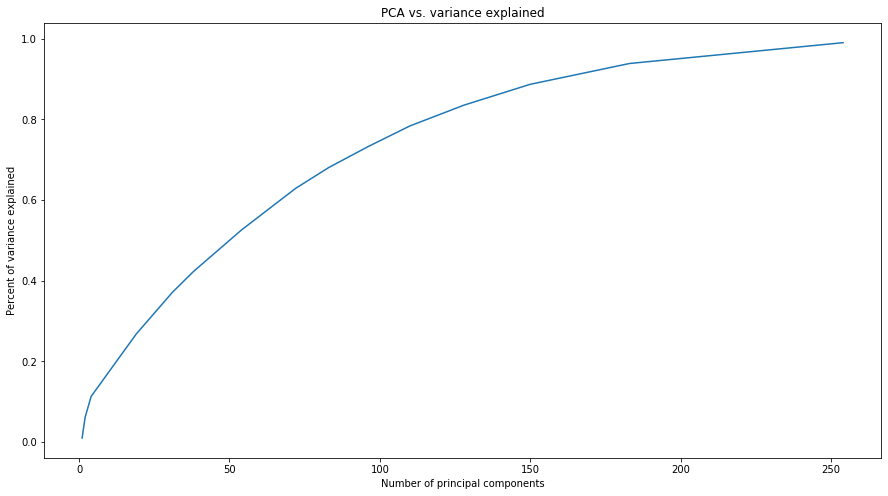

In [46]:
plt.figure(figsize = (15, 8))
plt.plot(components, dim_list)
plt.xlabel("Number of principal components")
plt.ylabel("Percent of variance explained")
plt.title("PCA vs. variance explained");

## I can see that with 200 components I´ll be more than happy, the exact variance explained by 200 components is more than 95%

In [63]:
train_matrix = PCA(n_components = 200).fit_transform(train_matrix)
test_matrix = pca.transform(test_matrix)
var = np.sum(pca.explained_variance_ratio_)
print(var)

0.9573505245618369


## Now I fit a quick logistic regressor as a benchmark. Not a great performance.

In [84]:
Lreg = LogisticRegression(max_iter = 1e3, penalty = "l1", C = 10).fit(train_matrix, y_train)

pred = Lreg.predict(test_matrix)

acc = Lreg.score(test_matrix, y_test)

print(acc)


0.5175


C:\Utilidades\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


## What about a random forest? It´s a bit better!!

In [90]:
RF = RandomForestClassifier(n_jobs = -1, n_estimators = 500, criterion = "gini").fit(train_matrix, y_train)

pred = RF.predict(test_matrix)

acc = RF.score(test_matrix, y_test)

print(acc)

0.5575
